In [1]:
#import dependencies
import keras
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, SpatialDropout1D, Input, concatenate, Conv1D, GlobalMaxPool1D, Dropout
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#set hyperparameters
output_dir = 'model_output/multiconv'

#training
epochs = 4
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 5000
max_review_length = 400 
pad_type = trunc_type = 'pre'
drop_embed = 0.2

#convolutional layer architecture
n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

#dense layer architecture
n_dense = 256
dropout = 0.2

In [7]:
#model architecture
#input layer:
input_layer = Input(shape=(max_review_length,),
                    dtype='int16', name='input')

#embedding:
embedding_layer = Embedding(n_unique_words, n_dim,
                    name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)


#three parallel convolutional streams
conv_1 = Conv1D(n_conv_1, k_conv_1,
                activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPool1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2,
                activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPool1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3,
                  activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPool1D(name='maxp_3')(conv_3)

#concatenate the activations from the three streams
concat = concatenate([maxp_1,maxp_2, maxp_3])

#dense hidden layers
dense_layer = Dense(n_dense,
                    activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(int(n_dense/4),
                activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

#output layer
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

#create model
model = Model(input_layer, predictions)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 64)      320000      ['input[0][0]']                  
                                                                                                  
 drop_embed (SpatialDropout1D)  (None, 400, 64)      0           ['embedding[0][0]']              
                                                                                                  
 conv_1 (Conv1D)                (None, 398, 256)     49408       ['drop_embed[0][0]']             
                                                                                              

In [5]:
#data preprocessing
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)
#standardizing input length by padding and truncating
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
#Create an object and directory for checkpoint model parameters after each epoch
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/Multi-CNNweights.{epoch:02d}.hdf5")

if not os.path.exists((output_dir)):
    os.makedirs(output_dir)

In [11]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 74s 373ms/step - loss: 0.4975 - accuracy: 0.7274 - val_loss: 0.3191 - val_accuracy: 0.8617
Epoch 2/4
196/196 [==============================] - 72s 365ms/step - loss: 0.2497 - accuracy: 0.9009 - val_loss: 0.2615 - val_accuracy: 0.8935
Epoch 3/4
196/196 [==============================] - 73s 374ms/step - loss: 0.1718 - accuracy: 0.9369 - val_loss: 0.2742 - val_accuracy: 0.8915
Epoch 4/4
196/196 [==============================] - 76s 389ms/step - loss: 0.1235 - accuracy: 0.9573 - val_loss: 0.2962 - val_accuracy: 0.8917


In [12]:
model.load_weights(output_dir+"/Multi-CNNweights.02.hdf5")

In [13]:
y_hat = model.predict_on_batch(x_valid)

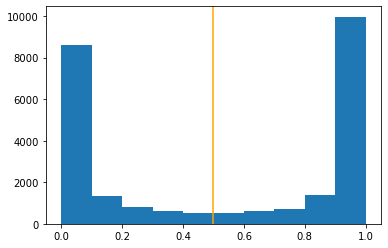

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
pct_auc = roc_auc_score(y_valid, y_hat) * 100
"{:0.2f}".format(pct_auc)

'93.04'